In [1]:
import os
import sys
from datetime import datetime
import pandas as pd
import random as rd
import numpy as np
import torch
from torch import nn
from torch import autograd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import Image, display
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The CUDNN backend version: {}'.format(now, torch.backends.cudnn.version()))
USE_CUDA = True

[LOG 20240509-10:15:41] The CUDNN backend version: None


In [5]:
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 20240509-10:15:48] The Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


In [6]:
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 20240509-10:15:53] The PyTorch version: 2.0.1+cpu


In [7]:
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

In [10]:
ori_dataset = pd.read_csv('fraud_dataset_v2.csv')
ori_dataset.head()

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular


In [11]:
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] Transactional dataset of {} rows and {} columns loaded'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))
     

[LOG 20240509-10:16:51] Transactional dataset of 533009 rows and 10 columns loaded


In [12]:
ori_dataset.head(10) 

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


In [13]:
ori_dataset.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

In [14]:
label = ori_dataset.pop('label')
ori_dataset.head(10)

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00


Text(0.5, 1.0, 'Distribution of HKONT attribute values')

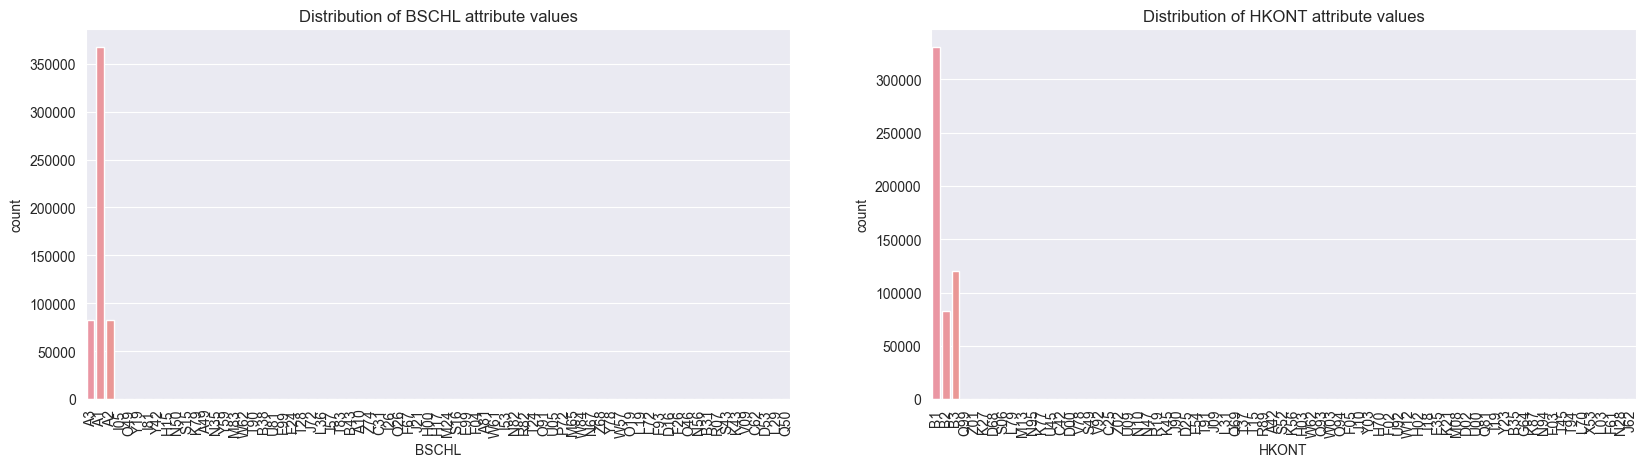

In [15]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)
g = sns.countplot(x=ori_dataset['BSCHL'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of BSCHL attribute values')
g = sns.countplot(x=ori_dataset['HKONT'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of HKONT attribute values')


In [17]:
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT','WAERS', 'BUKRS']
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])
ori_dataset_categ_transformed.head(10)

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,BUKRS_W67,BUKRS_W69,BUKRS_W71,BUKRS_W77,BUKRS_W86,BUKRS_X34,BUKRS_Y41,BUKRS_Y63,BUKRS_Z78,BUKRS_Z98
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Distribution of WRBTR amount values')

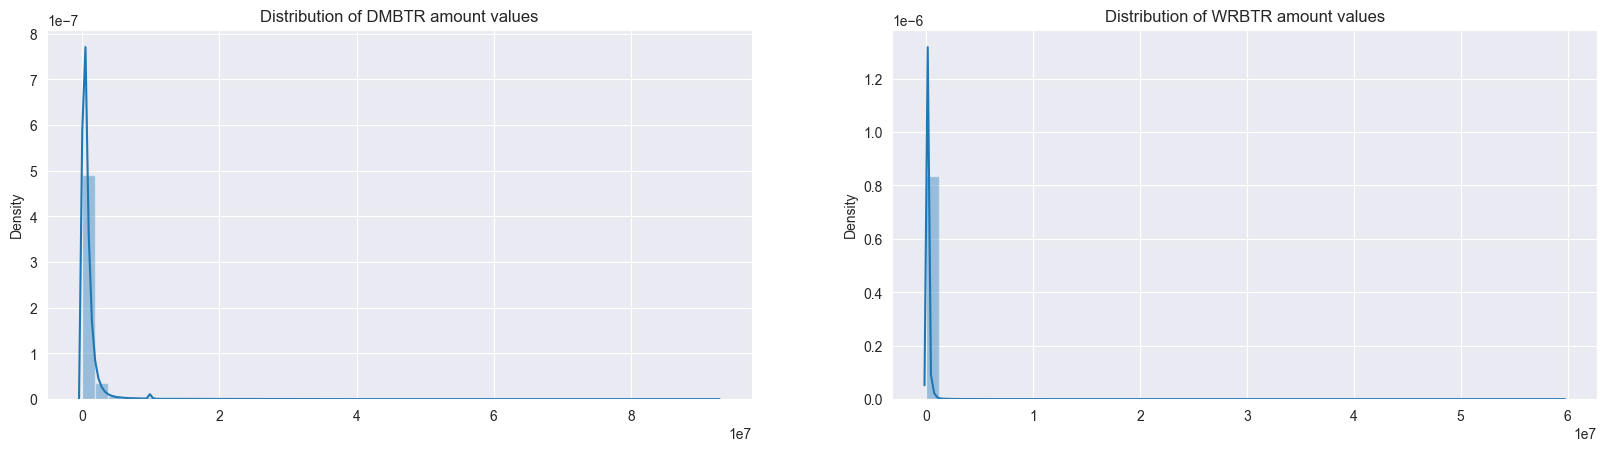

In [18]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

g = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

g = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

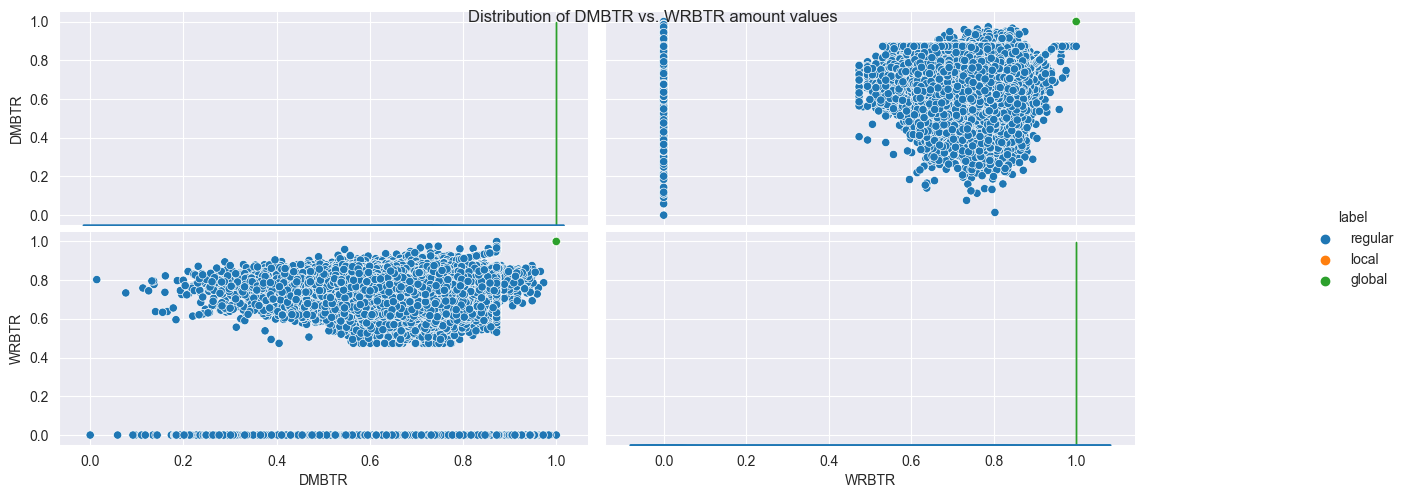

In [20]:
numeric_attr_names = ['DMBTR', 'WRBTR']

numeric_attr = ori_dataset[numeric_attr_names] + 1e-7
numeric_attr = numeric_attr.apply(np.log)

ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

numeric_attr_vis = ori_dataset_numeric_attr.copy()
numeric_attr_vis['label'] = label

g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label')
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values')
g.fig.set_size_inches(15, 5)

In [21]:
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)
ori_subset_transformed.shape

(533009, 618)

In [22]:
import gc

gc.collect()

201

In [23]:
class encoder(nn.Module):

    def __init__(self):
        super(encoder, self).__init__()
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=3, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights according to [9]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]
        
    def forward(self, x):
        x = self.encoder_R1(self.encoder_L1(x))

        return x

In [24]:

encoder_train = encoder()

if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    encoder_train = encoder().cuda()

In [25]:
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20240509-10:20:01] encoder architecture:

encoder(
  (encoder_L1): Linear(in_features=618, out_features=3, bias=True)
  (encoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
)



In [26]:
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()
        self.decoder_L1 = nn.Linear(in_features=3, out_features=ori_subset_transformed.shape[1], bias=True) # add linearity 
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights according to [9]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

    def forward(self, x):
        x = self.decoder_R1(self.decoder_L1(x)) 
        
        return x

In [27]:
decoder_train = decoder()

if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    decoder_train = decoder().cuda()
    
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20240509-10:20:30] decoder architecture:

decoder(
  (decoder_L1): Linear(in_features=3, out_features=618, bias=True)
  (decoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
)



In [29]:
loss_function = nn.BCEWithLogitsLoss(reduction='mean')
learning_rate = 1e-3
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

num_epochs = 5
mini_batch_size = 128
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    dataloader = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=True)



In [31]:
losses = []
data = autograd.Variable(torch_dataset)
for epoch in range(num_epochs):
    mini_batch_count = 0
    if(torch.backends.cudnn.version() != None) and (USE_CUDA == True):
        encoder_train.cuda()
        decoder_train.cuda()

    encoder_train.train()
    decoder_train.train()

    start_time = datetime.now()
        
    for mini_batch_data in dataloader:

        mini_batch_count += 1

        mini_batch_torch = autograd.Variable(mini_batch_data)

        z_representation = encoder_train(mini_batch_torch)
        mini_batch_reconstruction = decoder_train(z_representation)
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_torch)
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()
        reconstruction_loss.backward()
        decoder_optimizer.step()
        encoder_optimizer.step()
        if mini_batch_count % 1000 == 0:
            mode = 'GPU' if (torch.backends.cudnn.version() != None) and (USE_CUDA == True) else 'CPU'
            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            end_time = datetime.now() - start_time
            print('[LOG {}] training status, epoch: [{:04}/{:04}], batch: {:04}, loss: {}, mode: {}, time required: {}'.format(now, (epoch+1), num_epochs, mini_batch_count, np.round(reconstruction_loss.item(), 4), mode, end_time))
            start_time = datetime.now()
    encoder_train.cpu().eval()
    decoder_train.cpu().eval()

    reconstruction = decoder_train(encoder_train(data))

    reconstruction_loss_all = loss_function(reconstruction, data)
            
    losses.extend([reconstruction_loss_all.item()])
    
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] training status, epoch: [{:04}/{:04}], loss: {:.10f}'.format(now, (epoch+1), num_epochs, reconstruction_loss_all.item()))

    encoder_model_name = "ep_{}_encoder_model.pth".format((epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("models", encoder_model_name))

    decoder_model_name = "ep_{}_decoder_model.pth".format((epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("models", decoder_model_name))

    gc.collect()

[LOG 20240509-10:24:03] training status, epoch: [0001/0005], batch: 1000, loss: 0.0267, mode: CPU, time required: 0:00:03.917572
[LOG 20240509-10:24:06] training status, epoch: [0001/0005], batch: 2000, loss: 0.0235, mode: CPU, time required: 0:00:03.199777
[LOG 20240509-10:24:09] training status, epoch: [0001/0005], batch: 3000, loss: 0.0229, mode: CPU, time required: 0:00:03.460997
[LOG 20240509-10:24:13] training status, epoch: [0001/0005], batch: 4000, loss: 0.0213, mode: CPU, time required: 0:00:03.375976
[LOG 20240509-10:24:25] training status, epoch: [0001/0005], loss: 0.0215804465
[LOG 20240509-10:24:31] training status, epoch: [0002/0005], batch: 1000, loss: 0.0217, mode: CPU, time required: 0:00:04.841343
[LOG 20240509-10:24:34] training status, epoch: [0002/0005], batch: 2000, loss: 0.0214, mode: CPU, time required: 0:00:03.712078
[LOG 20240509-10:24:38] training status, epoch: [0002/0005], batch: 3000, loss: 0.0208, mode: CPU, time required: 0:00:03.756602
[LOG 20240509-10:

Text(0.5, 1.0, 'AENN training performance')

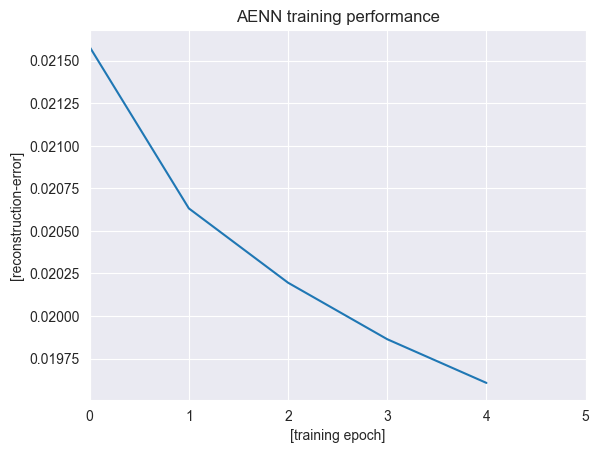

In [32]:
plt.plot(range(0, len(losses)), losses)
plt.xlabel('[training epoch]')
plt.xlim([0, len(losses)])
plt.ylabel('[reconstruction-error]')
plt.title('AENN training performance')

In [49]:
encoder_model_name = "C:\Users\lenovo\Documents\CS Projects\Machine Learning\Financial Transaction Anomaly Detection\models\ep_5_encoder_model.pth"
decoder_model_name = "C:\Users\lenovo\Documents\CS Projects\Machine Learning\Financial Transaction Anomaly Detection\models\ep_5_decoder_model.pth"

encoder_eval = encoder()
decoder_eval = decoder()

encoder_eval.load_state_dict(torch.load(os.path.join("models", encoder_model_name)))
decoder_eval.load_state_dict(torch.load(os.path.join("models", decoder_model_name)))
     

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (358939846.py, line 1)

In [50]:
data = autograd.Variable(torch_dataset)

encoder_eval.eval()
decoder_eval.eval()

reconstruction = decoder_eval(encoder_eval(data))

In [51]:
reconstruction_loss_all = loss_function(reconstruction, data)

now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] collected reconstruction loss of: {:06}/{:06} transactions'.format(now, reconstruction.size()[0], reconstruction.size()[0]))
print('[LOG {}] reconstruction loss: {:.10f}'.format(now, reconstruction_loss_all.item()))

[LOG 20240509-10:29:48] collected reconstruction loss of: 533009/533009 transactions
[LOG 20240509-10:29:48] reconstruction loss: 0.7395750880


In [52]:
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

for i in range(0, reconstruction.size()[0]):
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], data[i]).item()

    if(i % 100000 == 0):
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))
        
     

[LOG 20240509-10:29:57] collected individual reconstruction loss of: 000000/533009 transactions
[LOG 20240509-10:30:04] collected individual reconstruction loss of: 100000/533009 transactions
[LOG 20240509-10:30:10] collected individual reconstruction loss of: 200000/533009 transactions
[LOG 20240509-10:30:16] collected individual reconstruction loss of: 300000/533009 transactions
[LOG 20240509-10:30:23] collected individual reconstruction loss of: 400000/533009 transactions
[LOG 20240509-10:30:29] collected individual reconstruction loss of: 500000/533009 transactions


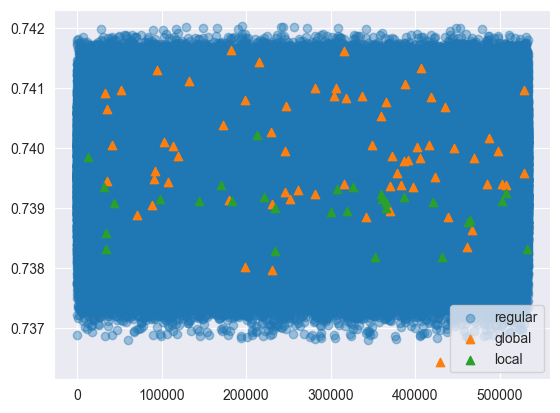

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)

plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))

regular_data = plot_data[label == 'regular']
global_outliers = plot_data[label == 'global']
local_outliers = plot_data[label == 'local']

ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', alpha=0.4, marker="o", label='regular') # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="^", label='global') # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C2', marker="^", label='local') # plot local outliers

ax.legend(loc='best')

In [54]:
ori_dataset['label'] = label

ori_dataset[reconstruction_loss_transaction >= 0.1].head()

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular


In [58]:
ori_dataset[(reconstruction_loss_transaction >= 0.05) & (reconstruction_loss_transaction <= 0.09)]

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
